# Looking at KIC 8462852 ([Boyajian's star](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=TYC+3162-665-1)) with [gPhoton](https://archive.stsci.edu/prepds/gphoton/)

Using the time-tagged photon data from GALEX, available with gPhoton, lets make some light curves of "Tabby's Star"

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from gPhoton import gFind
from gPhoton import gAperture
from gPhoton import gMap
from gPhoton.gphoton_utils import read_lc
import datetime

from astropy.time import Time
from gatspy.periodic import LombScargleFast

import extinction

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
ra = 301.5644
dec = 44.45684

## Searching for GALEX visits

Looks like there are 4 visits available in the database

In [4]:
exp_data = gFind(band='NUV', skypos=[ra, dec], exponly=True)

exp_data

NUV: 3311.0s (raw) in 4 exposures.


{'NUV': {'expt': 3311.0,
  'nearest_source': {'distance': 6.5512874478239989e-05,
   'mag': 16.460850000000001,
   'skypos': [301.564352375925, 44.4567839963424]},
  't0': array([  9.93336632e+08,   9.93367098e+08,   9.95690522e+08,
           9.99270098e+08]),
  't1': array([  9.93338307e+08,   9.93367186e+08,   9.95691962e+08,
           9.99270206e+08])}}

... and they seem to be spaced over about 2 months time. 

Alas, not the multi-year coverage I'd hoped for to compare with the results from [Montet & Simon (2016)](https://arxiv.org/abs/1608.01316)

In [5]:
(exp_data['NUV']['t0'] - exp_data['NUV']['t0'][0]) / (60. * 60. * 24. * 365.)

array([ 0.        ,  0.00096607,  0.07464136,  0.18814897])

## Making light curves
Following examples in the [repo](https://github.com/cmillion/gPhoton/tree/master/examples)...

In [6]:
# step_size = 20. # the time resolution in seconds

# # img_step_size = 30.
# # img_size = [0.1, 0.1]
# phot_rad = 0.0045 # in deg
# ap_in = 0.0050 # in deg
# ap_out = 0.0060 # in deg


In [7]:
target = 'KIC8462852'

# print(datetime.datetime.now())
# for k in range(len(exp_data['NUV']['t0'])):
#     photon_events = gAperture(band='NUV', skypos=[ra, dec], stepsz=step_size, radius=phot_rad,
#                               annulus=[ap_in, ap_out], verbose=3, csvfile=target+ '_' +str(k)+"_lc.csv",
#                               trange=[int(exp_data['NUV']['t0'][k]), int(exp_data['NUV']['t1'][k])+1], 
#                               overwrite=True)
    
#     print(datetime.datetime.now(), k)

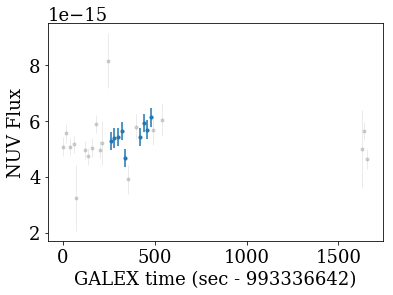

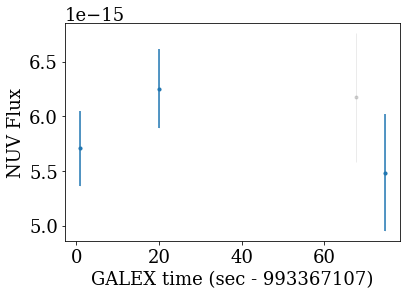

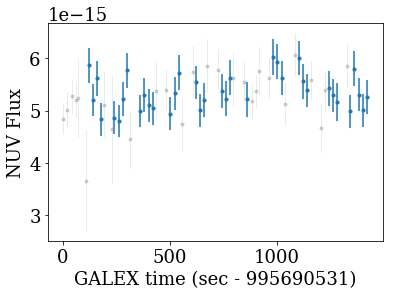

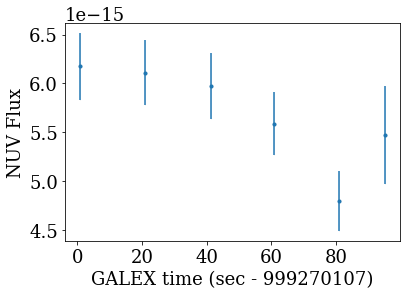

In [30]:
med_flux = np.array(np.zeros(len(exp_data['NUV']['t0'])), dtype='float')
med_flux_err = np.array(np.zeros(len(exp_data['NUV']['t0'])), dtype='float')

time_big = np.array([], dtype='float')
mag_big = np.array([], dtype='float')
flux_big = np.array([], dtype='float')

for k in range(len(exp_data['NUV']['t0'])):
    data = read_lc(target+ '_' +str(k)+"_lc.csv")
    med_flux[k] = np.nanmedian(data['flux_bgsub'])
    med_flux_err[k] = np.std(data['flux_bgsub'])

    time_big = np.append(time_big, data['t_mean'])
    flux_big = np.append(flux_big, data['flux_bgsub'])
    mag_big = np.append(mag_big, data['mag'])
    
    t0k = int(data['t_mean'][0])
    flg0 = np.where((data['flags'] == 0))[0]
    plt.figure()
    plt.errorbar(data['t_mean'] - t0k, data['flux_bgsub'], yerr=data['flux_bgsub_err'], 
             marker='.', linestyle='none', c='grey', alpha=0.3, lw=0.5)
    plt.errorbar(data['t_mean'][flg0] - t0k, data['flux_bgsub'][flg0], yerr=data['flux_bgsub_err'][flg0], 
             marker='.', linestyle='none')
    plt.xlabel('GALEX time (sec - '+str(t0k)+')')
    plt.ylabel('NUV Flux')
    plt.savefig(target+ '_' +str(k)+"_lc.pdf", dpi=150, bbox_inches='tight', pad_inches=0.25)
#     plt.close()

**Huh**... that 3rd panel looks like a nice long visit. Let's take a slightly closer look!

In [9]:
# k=2
# data = read_lc(target+ '_' +str(k)+"_lc.csv")

# t0k = int(data['t_mean'][0])
# plt.figure(figsize=(14,5))
# plt.errorbar(data['t_mean'] - t0k, data['flux_bgsub'], yerr=data['flux_bgsub_err'], marker='.', linestyle='none')
# plt.xlabel('GALEX time (sec - '+str(t0k)+')')
# plt.ylabel('NUV Flux')


Any *short* timescale variability of note? Let's use a Lomb-Scargle to make a periodogram!

(limited to the 10sec windowing I imposed... NOTE: gPhoton could easily go shorter, but S/N looks dicey)

Answer: Some interesting structure around 70-80 sec, but nothing super strong

**Update:** [David Wilson says](https://twitter.com/astrodave2/status/867495209537478656) that although there are significant pointing motions (which [Scott Flemming says](https://twitter.com/ScottWFleming/status/867473027709231104) do occur), they don't align with the ~80sec signal here. Short timescale may be interesting! However, [Keaton Bell says](https://twitter.com/astrokeat/status/867471075038433280) he saw no short timescale variations in optical last week...

**Update 2:** This ~80 sec structure seems to be present in the gPhoton data at all three of (9,10,11) second sampling, suggesting it is real.

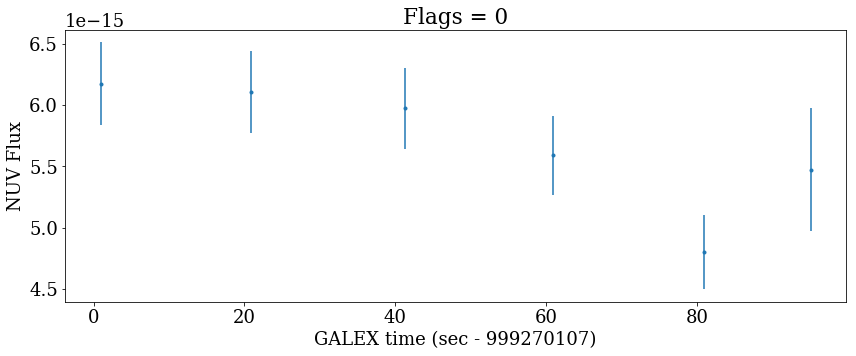

In [10]:
# try cutting on flags=0
flg0 = np.where((data['flags'] == 0))[0]
plt.figure(figsize=(14,5))
plt.errorbar(data['t_mean'][flg0] - t0k, data['flux_bgsub'][flg0], yerr=data['flux_bgsub_err'][flg0], 
             marker='.', linestyle='none')
plt.xlabel('GALEX time (sec - '+str(t0k)+')')
plt.ylabel('NUV Flux')
plt.title('Flags = 0')

(10, 500)

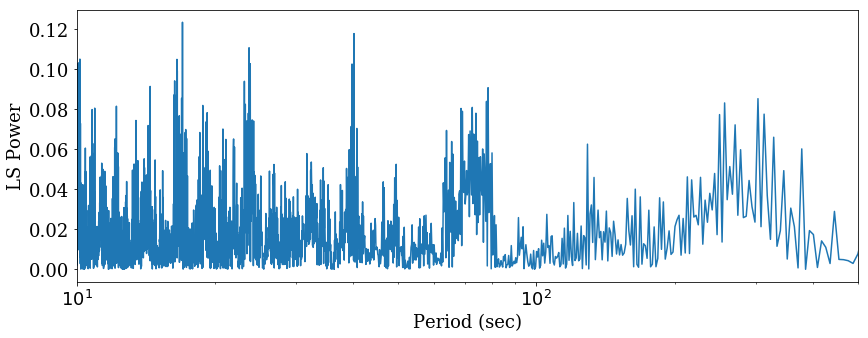

In [11]:
minper = 10 # my windowing
maxper = 10000
nper = 2000
pgram = LombScargleFast(fit_offset=False)
pgram.optimizer.set(period_range=(minper,maxper))

pgram = pgram.fit(time_big - min(time_big), flux_big - np.nanmedian(flux_big))

df = (1./minper - 1./maxper) / nper
f0 = 1./maxper

pwr = pgram.score_frequency_grid(f0, df, nper)

freq = f0 + df * np.arange(nper)
per = 1./freq

##
plt.figure(figsize=(14,5))
plt.plot(per, pwr)
plt.xlabel('Period (sec)')
plt.ylabel('LS Power')
plt.xscale('log')
plt.xlim(10,500)

How about the long-term evolution?

Answer: looks flat!

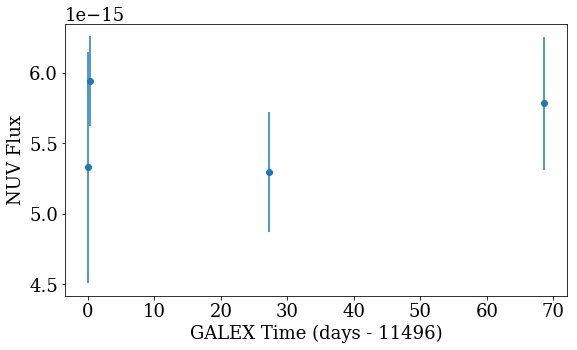

In [39]:
plt.figure(figsize=(9,5))
plt.errorbar((exp_data['NUV']['t0'] - exp_data['NUV']['t0'][0]) / (60.*60.*24.), med_flux, yerr=med_flux_err,
             linestyle='none', marker='o')
plt.xlabel('GALEX Time (days - ' + str(int( exp_data['NUV']['t0'][0] / (60.*60.*24. ))) + ')')
plt.ylabel('NUV Flux')
# plt.title(target)
plt.savefig(target+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)


## Conclusion...?
Based on data from only 4 GALEX visits, spaced over ~70 days, we can't say much possible evolution of this star with GALEX.

In [13]:
# average time of the gPhoton data
print(np.mean(exp_data['NUV']['t0']))
t_unix = Time(np.mean(exp_data['NUV']['t0']) + 315964800, format='unix')
t_date = t_unix.yday
print(t_date)

mjd_date = t_unix.mjd
print(mjd_date)

995416087.495
2011:204:00:28:07.495
55765.0195312


The visits are centered in mid 2011 (Quarter 9 and 10, I believe)

Note: there was a [special GALEX pointing at the Kepler field](http://galex.stsci.edu/gr6/?page=scanmode) that overlapped with Quarter 14 - approximately 1 year later. This data is not available via gPhoton, but it may be able to be used! The gPhoton data shown here occurs right *before* the "knee" in Figure 3 of [Montet & Simon (2016)](https://arxiv.org/abs/1608.01316), and Quarter 14 is well after. **Therefore a ~3% dip in the flux *should* be observed between this data and the Q14 visit**

However: the per-vist errors shown here (std dev) are around 6-10% for this target. If we co-add it all, we may get enough precision. The Q14 data apparently has 15 total scans... so the measurment may be borderline possible!

## Update: Out on a limb
I followed up on both the GALEX archival flux mearument, and the published scan-mode flux.

The GALEX source database from MAST (from which *I believe* gPhoton is derived) [says](http://galex.stsci.edu/GR6/?page=explore&photo=true&objid=3728666168841474091) m_NUV = 16.46 +/- 0.01

The "Deep GALEX NUV survey of the Kepler field" catalog by Olmedo (2015), aka GALEX CAUSE Kepler, [says](http://vizier.cfa.harvard.edu/viz-bin/VizieR-5?-ref=VIZ5925faa6255b&-out.add=.&-source=J/ApJ/813/100/table4&recno=660470) m_NUV = 16.499 +/- 0.006

Converting these <a href="https://en.wikipedia.org/wiki/Magnitude_(astronomy)"> magnitudes </a> to a change in flux:

    10^((16.46 - 16.499) / (-2.5)) = 1.03657
    
And if you trust all those catalog values as stated, here is a **highly suggestive** plot:

(16.52, 16.44)

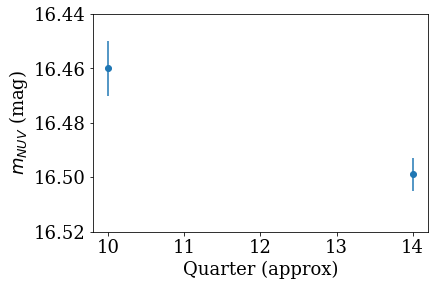

In [14]:
plt.errorbar([10, 14], [16.46, 16.499], yerr=[0.01, 0.006], linestyle='none', marker='o')
plt.xlabel('Quarter (approx)')
plt.ylabel(r'$m_{NUV}$ (mag)')
plt.ylim(16.52,16.44)

For time comparison, here is an example MJD from scan 15 of the GKM data.

(note: I grabbed a random time-like number from [here](http://archive.stsci.edu/pub/galex/KS/pipe/01-vsn/29214-KEPLER_SCAN_015/d/00-visits/0009-img/02-try/Out.txt). YMMV, but it's probably OK for comparing to the Kepler FFI results)

In [15]:
gck_time = Time(1029843320.995 + 315964800, format='unix')
gck_time.mjd

56163.48288188657

In [16]:
# and to push the comparison to absurd places...
# http://astro.uchicago.edu/~bmontet/kic8462852/reduced_lc.txt

df = pd.read_table('reduced_lc.txt', delim_whitespace=True, skiprows=1, 
                   names=('time','raw_flux', 'norm_flux', 'model_flux'))

# time = BJD-2454833
# *MJD = JD - 2400000.5

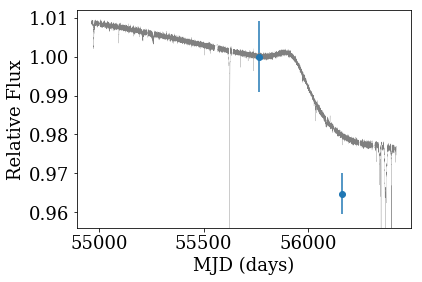

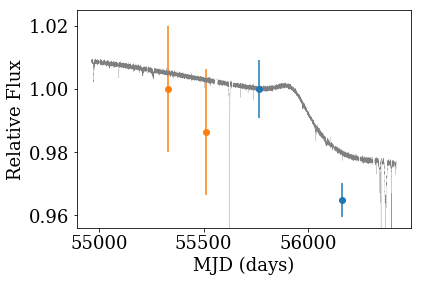

In [28]:
plt.figure()
plt.plot(df['time'] + 2454833 - 2400000.5, df['model_flux'], c='grey', lw=0.2)

gtime = [mjd_date, gck_time.mjd]
gmag = np.array([16.46, 16.499])
gflux = np.array([1, 10**((gmag[1] - gmag[0]) / (-2.5))])
gerr = np.abs(np.array([0.01, 0.006]) * np.log(10) / (-2.5) * gflux)

plt.errorbar(gtime, gflux, yerr=gerr, 
             linestyle='none', marker='o')
plt.ylim(0.956,1.012)
plt.xlabel('MJD (days)')
plt.ylabel('Relative Flux')

plt.savefig(target+'_compare.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

####################
# add in WISE
plt.figure()
plt.plot(df['time'] + 2454833 - 2400000.5, df['model_flux'], c='grey', lw=0.2)
plt.errorbar(gtime, gflux, yerr=gerr, 
             linestyle='none', marker='o')
# the WISE W1-band results from another notebook
wise_time = np.array([55330.86838, 55509.906929000004])
wise_flux = np.array([ 1.,0.98627949])
wise_err = np.array([ 0.02011393,  0.02000256])
plt.errorbar(wise_time, wise_flux, yerr=wise_err,
             linestyle='none', marker='o')
plt.ylim(0.956,1.025)
plt.xlabel('MJD (days)')
plt.ylabel('Relative Flux')

# plt.savefig(target+'_compare2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## Thinking about Dust - v1

Use basic values for the relative extinction in each band at a "standard" R_v = 3.1

Imagine if the long-term Kepler fading was due to dust. What is the extinction we'd expect in the NUV? (A: Much greater)

In [18]:
# considering extinction... 
# w/ thanks to the Padova Isochrone page for easy shortcut to getting these extinction values:
# http://stev.oapd.inaf.it/cgi-bin/cmd

A_NUV = 2.27499 # actually A_NUV / A_V, in magnitudes, for R_V = 3.1
A_Kep = 0.85946 # actually A_Kep / A_V, in magnitudes, for R_V = 3.1
A_W1 = 0.07134 # actually A_W1 / A_V, in magnitudes, for R_V = 3.1

wave_NUV = 2556.69 # A
wave_Kep = 6389.68 # A
wave_W1 = 33159.26 # A


print('nuv')
# frac_kep = 1 + (np.median(df['model_flux'][0:100]) - np.median(df['model_flux'][-100:]))
frac_kep = (np.median(df['model_flux'][np.where((np.abs(df['time']+ 2454833 - 2400000.5 -gtime[0])) < 25)[0]]) - 
            np.median(df['model_flux'][np.where((np.abs(df['time']+ 2454833 - 2400000.5 -gtime[1])) < 25)[0]]))
print(frac_kep)

mag_kep = -2.5 * np.log10(1.-frac_kep)
print(mag_kep)

mag_nuv = mag_kep / A_Kep * A_NUV
print(mag_nuv)

frac_nuv = 10**(mag_nuv / (-2.5))
print(1-frac_nuv)



frac_kep_w = (np.median(df['model_flux'][np.where((np.abs(df['time']+ 2454833 - 2400000.5 -wise_time[0])) < 25)[0]]) - 
              np.median(df['model_flux'][np.where((np.abs(df['time']+ 2454833 - 2400000.5 -wise_time[1])) < 25)[0]]))
print('w1')
print(frac_kep_w)
mag_kep_w = -2.5 * np.log10(1.-frac_kep_w)
print(mag_kep_w)
mag_w1 = mag_kep_w / A_Kep * A_W1
print(mag_w1)
frac_w1 = 10**(mag_w1 / (-2.5))
print(1-frac_w1)



nuv
0.0204333663149
0.0224150409356
0.0593325971867
0.0531810071738
w1
0.00215242040507
0.00233947943748
0.000194189913515
0.000178839526333


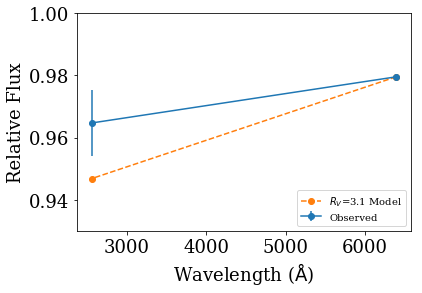

In [29]:
plt.errorbar([wave_Kep, wave_NUV], [1-frac_kep, gflux[1]], yerr=[0, np.sqrt(np.sum(gerr**2))], 
             label='Observed', marker='o')
plt.plot([wave_Kep, wave_NUV], [1-frac_kep, frac_nuv], '--o', label=r'$R_V$=3.1 Model')
plt.legend(fontsize=10, loc='lower right')
plt.xlabel(r'Wavelength ($\rm\AA$)')
plt.ylabel('Relative Flux')
plt.ylim(0.93,1)
plt.savefig(target+'_extinction_model_1.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

(0.93, 1.03)

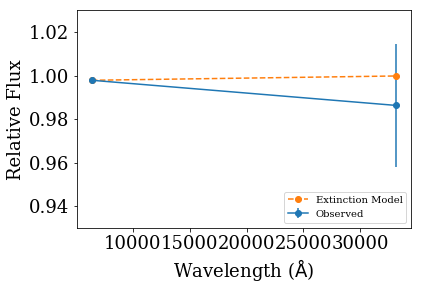

In [20]:
plt.errorbar([wave_Kep, wave_W1], [1-frac_kep_w, wise_flux[1]], yerr=[0, np.sqrt(np.sum(wise_err**2))], 
             label='Observed', marker='o')
plt.plot([wave_Kep, wave_W1], [1-frac_kep_w, frac_w1], '--o', label='Extinction Model')
plt.legend(fontsize=10, loc='lower right')
plt.xlabel(r'Wavelength ($\rm\AA$)')
plt.ylabel('Relative Flux')
plt.ylim(0.93,1.03)
# plt.savefig(target+'_extinction_model_2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

Combining the fading and dust model for both the NUV and W1 data.

In the IR we can't say much... so maybe toss it out since it doesn't constrain dust model one way or another

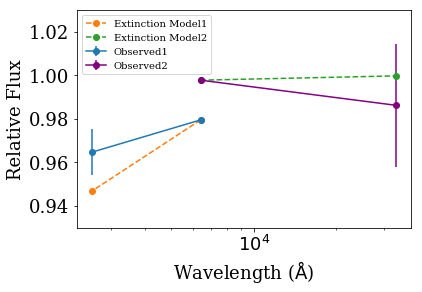

In [21]:
plt.errorbar([wave_Kep, wave_NUV], [1-frac_kep, gflux[1]], yerr=[0, np.sqrt(np.sum(gerr**2))], 
             label='Observed1', marker='o')
plt.plot([wave_Kep, wave_NUV], [1-frac_kep, frac_nuv], '--o', label='Extinction Model1')


plt.errorbar([wave_Kep, wave_W1], [1-frac_kep_w, wise_flux[1]], yerr=[0, np.sqrt(np.sum(wise_err**2))], 
             label='Observed2', marker='o', c='purple')
plt.plot([wave_Kep, wave_W1], [1-frac_kep_w, frac_w1], '--o', label='Extinction Model2')
plt.legend(fontsize=10, loc='upper left')
plt.xlabel(r'Wavelength ($\rm\AA$)')
plt.ylabel('Relative Flux')
plt.ylim(0.93,1.03)
plt.xscale('log')
# plt.savefig(target+'_extinction_model_2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## Dust 2.0: Let's fit some models to the Optical-NUV data!

Start w/ simple dust model, try to fit for R_V

The procedure will be:

- for each R_V I want to test
- figure out what A_Kep / A_V is for this R_V
- solve for A_NUV(R_V) given measured A_Kep

In [22]:
# the "STANDARD MODEL" for extinction
A_V = 0.0265407
R_V = 3.1

ext_out = extinction.ccm89(np.array([wave_Kep, wave_NUV]), A_V, R_V)

# (ext_out[1] - ext_out[0]) / ext_out[1]
print(10**(ext_out[0]/(-2.5)), (1-frac_kep)) # these need to match (within < 1%)
print(10**(ext_out[1]/(-2.5)), gflux[1]) # and then these won't, as per our previous plot

# print(10**((ext_out[1] - ext_out[0])/(-2.5)) / 10**(ext_out[0]/(-2.5)))

(0.97956663646392084, 0.97956663368507457)
(0.94725284045914482, 0.96471715189616947)


In [23]:
# now find an R_V (and A_V) that gives matching extinctions in both bands
# start by doing a grid over plasible A_V values at each R_V I care about... we doing this brute force!

ni=50
nj=50
di = 0.2
dj = 0.0003
ext_out_grid = np.zeros((2,ni,nj))
for i in range(ni):
    R_V = 1.1 + i*di
    for j in range(nj):
        A_V = 0.02 + j*dj

        ext_out_ij = extinction.ccm89(np.array([wave_Kep, wave_NUV]), A_V, R_V)
        ext_out_grid[:,i,j] = 10**(ext_out_ij/(-2.5))
        
R_V_grid = 1.1 + np.arange(ni)*di
A_V_grid = 0.02 + np.arange(nj)*dj

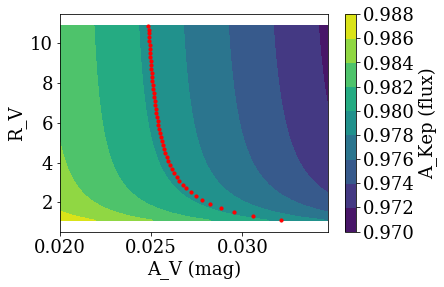

In [24]:
# now plot where the Kepler extinction (A_Kep) matches the measured value, for each R_V

plt.figure()
plt.contourf( A_V_grid, R_V_grid, ext_out_grid[0,:,:], origin='lower' )
cb = plt.colorbar()
cb.set_label('A_Kep (flux)')

A_V_match = np.zeros(ni)
ext_NUV = np.zeros(ni)
for i in range(ni):
    xx = np.interp(1-frac_kep, ext_out_grid[0,i,:][::-1], A_V_grid[::-1])
    plt.scatter(xx, R_V_grid[i], c='r', s=10)
    A_V_match[i] = xx
    ext_NUV[i] = 10**(extinction.ccm89(np.array([wave_NUV]),xx, R_V_grid[i]) / (-2.5))
    
plt.ylabel('R_V')
plt.xlabel('A_V (mag)')
plt.show()


5.02097489191
0.938304455977
0.0258814623379


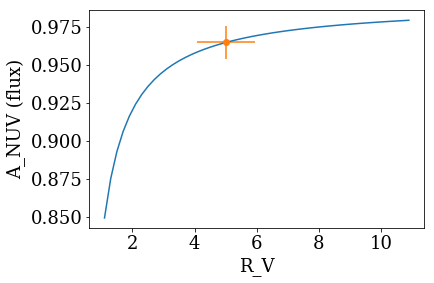

In [25]:
# Finally: at what R_V do we both match A_Kep (as above), and *now* A_NUV?

RV_final = np.interp(gflux[1], ext_NUV, R_V_grid)
print(RV_final)

RV_err = np.mean(np.interp([gflux[1] + np.sqrt(np.sum(gerr**2)), gflux[1] - np.sqrt(np.sum(gerr**2))], 
                           ext_NUV, R_V_grid)) - RV_final
print(RV_err)

AV_final = np.interp(gflux[1], ext_NUV, A_V_grid)
print(AV_final)

plt.plot(R_V_grid, ext_NUV)
plt.errorbar(RV_final, gflux[1], yerr=np.sqrt(np.sum(gerr**2)), xerr=RV_err, marker='o')
plt.xlabel('R_V')
plt.ylabel('A_NUV (flux)')



`CCM89` gives us R_V = 5.02097489191 +/- 0.938304455977 satisfies both the Kepler and NUV fading we see.

Such a high value of R_V~5 is not unheard of, [particulary in protostars](http://adsabs.harvard.edu/abs/1982ApJ...263L..39H), however Boyajian's Star does not show any other indications of being such a source.

**NOTE:**
If we re-run using `extinction.fitzpatrick99` instead of extinction
we get R_v = 5.80047674637 +/- 1.57810616272

In [26]:
# how much Hydrogen would you need to cause this fading?
# http://www.astronomy.ohio-state.edu/~pogge/Ast871/Notes/Dust.pdf
# based on data from Rachford et al. (2002) http://adsabs.harvard.edu/abs/2002ApJ...577..221R

A_Ic = extinction.ccm89(np.array([8000.]), AV_final, RV_final)
N_H = A_Ic / ((2.96 - 3.55 * ((3.1 / RV_final)-1)) * 1e-22)

print(N_H[0] , 'cm^-2')

# see also http://adsabs.harvard.edu/abs/2009MNRAS.400.2050G for R_V=3.1 only
print(2.21e21 * AV_final, 'cm^-2')

(4.0032122751082856e+19, 'cm^-2')
(5.719803176666584e+19, 'cm^-2')


In [27]:
1-gflux[1]

0.035282848103830533